---
toc: true
comments: true
layout: post
title: Personal Project - Lightcurve Synthesis
description: Python section for lightcurve synthesis with numpy and matplotlib only
type: hacks
courses: { csp: {week: 10, categories: [4.A]} }
categories: [C1.4]
---

# Synthesizing Realistic Circumbinary Transiting Planetary Light Curves
<p>This is a section of code from a AI-based scientific investigation of circumbinary planets. The actual specifics of the situation are difficult to explain concisely, but the goal of this code is essentially to generate a quasi-periodic signal overlain with Gaussian noise.</p>

#### Key Features:
- Transit features are inserted at semi-random locations using Numpy Gaussian distribution
- Array of randomly sampled Gaussian noise values overlain on synthesized data array, using passed SNR in the formula σ = depth * √(duration) / SNR
- Additional secondary transits generated randomly at an adjustable rate
- Occasionally, transit features are skipped to simulate precession-driven passage out of the alignment

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [15]:
def make_transit(t0, period, duration, depth, ratio):
    #t0: the coordinate of the transit with respect to the period window.
    #period: the period of the planet, in days.
    #duration: the length of the transit, in days.
    #depth: the depth of the transit with respect to the star's luminosity, from 0-1.
    #ratio: the ratio of sizes between the planet and the star, from 0-1.
    
    
    #final 30min resolution (0.25x)
    one_period_time = np.arange(0, period, 1/192)

    ab = duration * (1 - ratio) / 2
    bc = duration * ratio

    # Make x,y (time, flux) positions for each trapezoid marker
    a = [0, 1]
    b = [ab, 1 - depth]
    c = [ab + bc, 1 - depth]
    d = [duration, 1]

    x = np.array([a[0], b[0], c[0], d[0]])
    y = [a[1], b[1], c[1], d[1]]

    #reshape the array, take the mean on an axis
    one_period_flux = np.interp(one_period_time, x+t0, y)   
    
    #one_period_flux: an array containing the generated flux values.
    return one_period_flux
    
    
    
def transit_full(time, period, dur, depth, ratio, t0_spread=5, dur_spread=0.002, depth_spread=0.002,
                 tprob=0.7, t2prob=0.4, binsize=4, snr=10, fluxratio=1):
    #time: the size of the simulated lightcurve, in days.
    #period: the period of the planet, in days.
    #dur: the duration of the transit, in days.
    #depth: the depth of the transit with respect to the normal luminosity, from 0-1.
    #ratio: the ratio between the sizes of the planet and star, from 0-1.
    #t0_spread: the scatter in t0 between transits, in days.
    #dur_spread: the scatter in transit duration.
    #depth_spread: the scatter in transit depth.
    #tprob: the probability of a successful transit.
    #t2prob: the probability of a transit of the secondary star.
    #binsize: the size of bins, in datapoints.
    #snr: the signal-to-noise ratio, from 0-1.
    #fluxratio: the luminosity ratio between the primary and secondary stars.
    
    #Setup output and determine the number of periods.
    fulltransitcurve = []
    twindow = np.zeros(int(np.ceil(time/period)))
    np.random.default_rng()

    for i in range(0,int(np.ceil(time/period))):
        t_insert = np.random.uniform(0,1)
        
        #Generate randomised parameters for a transit injection
        if t_insert < tprob:
            t0_instance = period/2 + np.random.normal(0,t0_spread)
            dur_instance = np.random.normal(dur,dur_spread)
            depth_instance = np.random.normal(depth,depth_spread)
            tinstance = make_transit(t0_instance,period,dur_instance,depth_instance,ratio)
            
            #Generate parameters for a secondary transit
            if t_insert < t2prob:
                t2t0 = t0_instance + np.random.uniform(-5.0,5.0)
                t2 = make_transit(t2t0,period,dur_instance,depth_instance*fluxratio,ratio)
                tinstance = tinstance+t2-1
            
            fulltransitcurve += tinstance.tolist()

        #Skip a failed transit (precession shifts planet out of transit window)
        else:
            fulltransitcurve += [1.0]*int(period*192-1)

    #Add noise with the specified SNR
    sigma = depth * np.sqrt(dur) / snr #mark for review
    noise = np.random.normal(0.0, sigma, len(fulltransitcurve))
            
    fulltransitcurve += noise
    
    #Bin the synthesized light curve to the specified resolution
    n = -(len(fulltransitcurve)%binsize)
    if n == 0:
        tcarray = np.array(fulltransitcurve)
    else:
        tcarray = np.array(fulltransitcurve[:n])
    tcarray = tcarray.reshape(int(len(tcarray)/binsize),binsize)
    finallc = np.mean(tcarray,axis=1)
    
#     #Fold the simulated light curve
#     finalt = np.arange(0,len(finallc))
#     flc = lk.LightCurve(time=finalt,flux=finallc)
#     flcfolded = flc.fold(epoch_time=t0_instance,period=period).bin(bins=1000) #mark for review
    
    
    #finallc: the final simulated lightcurve, with 1 point each 30 minutes.
    return finallc

def make_negative(time, sigma):
    #time: the size of the light curve array desired, in days.
    #sigma: the spread of the gaussian noise distribution.
    
    noisearray = np.random.normal(1.0, sigma, time*48)
    
    #noisearray: the specified gaussian noise-only array. Assume 1 point = 30 minutes (it doesn't actually matter what the resolution is).
    return noisearray

67199


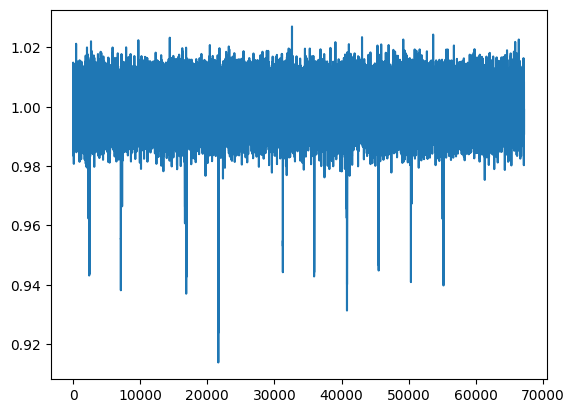

In [17]:
tc = transit_full(time=1400,period=100.0,dur=0.5,depth=0.05,ratio=0.8,t0_spread=1,
                  dur_spread=0.002,depth_spread=0.002,tprob=0.8,t2prob=0.5, snr=3, fluxratio=0.5)

print(len(tc))

#Changelog:
    #Customizable binning (set normally at 30min normal resolution)
    #Prefolding (probably could be more efficient)
    #Time now takes an integer
    #Added Gaussian noise with adjustable SNR - needs review
#To-do
    #anticlipping
    #return to complex binary parameters after
    
    
np.shape(tc)

plt.figure()
plt.plot(tc)

In [ ]:
neg = make_negative(300,0.05)
plt.figure()
plt.plot(neg)